In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip  /content/drive/MyDrive/irmas/IRMAS.zip -d /content
!unzip  /content/drive/MyDrive/irmas/kob.zip -d /content
!unzip  /content/drive/MyDrive/irmas/dom.zip -d /content

In [3]:
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import f1_score, roc_curve, precision_score, roc_auc_score, confusion_matrix
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.parameter import Parameter
from torchvision import models
import torchaudio as ta
import copy
import os

from scipy.special import logit, expit

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

In [4]:
classes_path = "/content/IRMAS/"
classes = os.listdir(classes_path)

train_dict = {'path': [], 'target':[]}

for inst in classes:
    files_path = classes_path + inst + "/"
    if inst[0] != 'R':
        files = os.listdir(files_path)
        train_dict['path'].extend(["/content/IRMAS/" + inst + "/" + file for file in files])
        train_dict['target'].extend([inst] * len(files))

path = "/content/dom/"
folder = os.listdir(path)

inst = "dom"

train_dict['path'].extend(["/content/dom/" + file for file in folder])
train_dict['target'].extend([inst] * len(folder))

path = "/content/kob/"
folder = os.listdir(path)

inst = "kob"

train_dict['path'].extend(["/content/kob/" + file for file in folder])
train_dict['target'].extend([inst] * len(folder))

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_dict['path'],train_dict['target'], test_size=0.20, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.125, random_state=42, shuffle=True)

test_df = pd.DataFrame({'path': x_test, 'target': y_test})
train_df = pd.DataFrame({'path': x_train, 'target': y_train})
val_df = pd.DataFrame({'path': x_val, 'target': y_val})

In [6]:
SR = 44100

len_audio = 3.0
n_mels = 128
fmin = 20
fmax = 16000
n_fft = 1024
hop_length = 512
GRADIENT_ACCUMULATION = 1
NFOLDS = 5

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

epochs = 15
batch_size = 32
batch_size_val = 64

In [7]:
INS_CODE = {}
INV_INS_CODE = {}
for i,label in enumerate(sorted(test_df.target.unique())):
    INS_CODE[label] = i
    INV_INS_CODE[i] = label

In [8]:
def get_audio(path,sr=SR):
    y, sample_rate = librosa.load(path, sr=sr)
    return y

def mono_to_color(X, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)

    mean = X.mean()
    std = X.std()
    X = (X - mean) / (std + eps)
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def normalize(image, mean=None, std=None):
    image = image / 255.0
    return np.moveaxis(image, 2, 0).astype(np.float32)

def compute_melspec(y):
    melspec = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=n_mels, fmin=fmin, fmax=fmax, n_fft=n_fft, hop_length=hop_length
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

In [16]:
class MusicDataset(Dataset):
    def __init__(self, data, test=False):
        super(MusicDataset, self).__init__()
        self.data = data
        self.test = test
        self.effective_length = int(SR * len_audio)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx: int):
        sample = self.data.loc[idx]

        waveform = get_audio(sample['path'])


        if len(waveform) > self.effective_length:
            waveform = waveform[:int(SR * len_audio)]
        elif len(waveform) == self.effective_length:
            pass
        else:
            new_wave = np.zeros(self.effective_length, dtype=waveform.dtype)
            start = np.random.randint(self.effective_length - len(waveform))
            new_wave[start:start + len(waveform)] = waveform
            waveform = new_wave.astype(np.float32)

        melspec = compute_melspec(waveform)
        image = mono_to_color(melspec)
        image = normalize(image)

        targets = INS_CODE[sample['target']]
        return image, targets


In [17]:
class Net(nn.Module):
    def __init__(self,out_dim):
        super(Net, self).__init__()
        self.out_dim = out_dim

        self.resnet = models.resnet50(weights='DEFAULT')
        self.num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.num_features,self.out_dim)

    def forward(self, x):
        return self.resnet(x)

In [18]:
train_dataset = MusicDataset(pd.DataFrame({'path': x_train, 'target':y_train}))
val_dataset = MusicDataset(pd.DataFrame({'path': x_val, 'target':y_val}))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

test_set = MusicDataset(test_df)
test_loader =  DataLoader(test_set, batch_size=1, shuffle=True)

In [19]:
model = Net(13).to(device)

In [20]:
dataloader = {
    'train':train_loader,
    'val':val_loader
}
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [21]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=20):
    start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0
            for x_batch, y_batch in dataloaders[phase]:
                inputs, labels = x_batch, y_batch
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history, train_loss_history, val_loss_history

In [22]:
model, val_acc_history, train_loss_history, val_loss_history = train_model(model, dataloader, optimizer, criterion, 30)

Epoch 0/29
----------
train Loss: 1.8759 Acc: 0.4208
val Loss: 1.3246 Acc: 0.5451
Epoch 1/29
----------
train Loss: 0.8552 Acc: 0.7225
val Loss: 0.9599 Acc: 0.6823
Epoch 2/29
----------
train Loss: 0.3874 Acc: 0.8836
val Loss: 0.9607 Acc: 0.6925
Epoch 3/29
----------
train Loss: 0.1513 Acc: 0.9624
val Loss: 0.9498 Acc: 0.7370
Epoch 4/29
----------
train Loss: 0.0795 Acc: 0.9817
val Loss: 0.9804 Acc: 0.7281
Epoch 5/29
----------
train Loss: 0.0613 Acc: 0.9853
val Loss: 0.9806 Acc: 0.7484
Epoch 6/29
----------
train Loss: 0.0445 Acc: 0.9904
val Loss: 1.1216 Acc: 0.7459
Epoch 7/29
----------
train Loss: 0.0458 Acc: 0.9891
val Loss: 1.1114 Acc: 0.7344
Epoch 8/29
----------
train Loss: 0.0425 Acc: 0.9882
val Loss: 1.0980 Acc: 0.7624
Epoch 9/29
----------
train Loss: 0.0530 Acc: 0.9844
val Loss: 0.9934 Acc: 0.7726
Epoch 10/29
----------
train Loss: 0.0294 Acc: 0.9916
val Loss: 1.0470 Acc: 0.7497
Epoch 11/29
----------
train Loss: 0.0496 Acc: 0.9860
val Loss: 1.1042 Acc: 0.7484
Epoch 12/29
--

In [23]:
import numpy as np

def plot_training_history(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')

    # Calculate the average losses
    average_train_loss = np.mean(train_loss_history)
    average_val_loss = np.mean(val_loss_history)

    # Display average losses on the plot
    plt.axhline(y=average_train_loss, color='r', linestyle='--', label=f'Average Training Loss: {average_train_loss:.4f}')
    plt.axhline(y=average_val_loss, color='b', linestyle='--', label=f'Average Validation Loss: {average_val_loss:.4f}')

    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

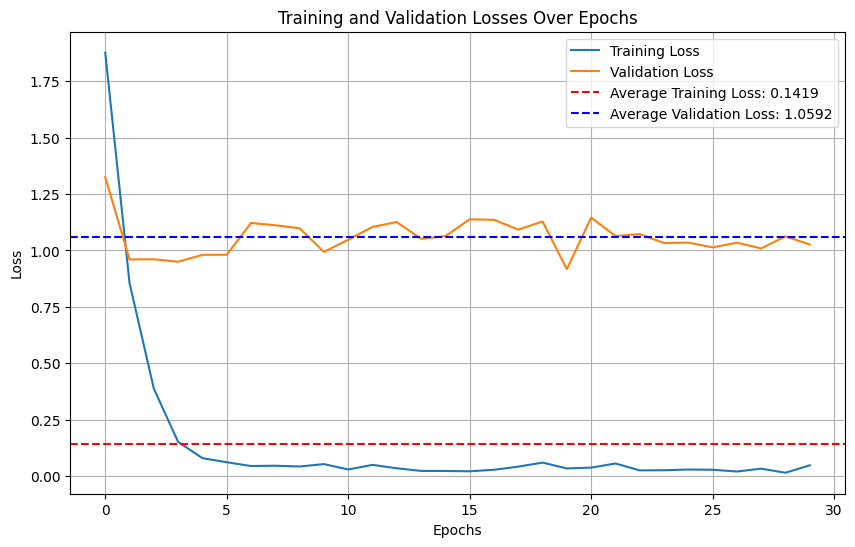

In [24]:
plot_training_history(train_loss_history, val_loss_history)

In [26]:
def test_model(model, dataloader):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_count = 0


    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            inputs, labels = x_batch, y_batch
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return all_labels, all_preds

In [27]:
all_labels, all_preds = test_model(model, test_loader)

In [28]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75        79
           1       0.64      0.73      0.68        86
           2       0.99      0.99      0.99       103
           3       0.76      0.68      0.71        96
           4       0.84      0.83      0.84       137
           5       0.68      0.78      0.73       148
           6       0.99      1.00      1.00       132
           7       0.84      0.80      0.82       137
           8       0.80      0.84      0.82       132
           9       0.64      0.71      0.67       115
          10       0.79      0.79      0.79       112
          11       0.71      0.55      0.62       128
          12       0.97      0.87      0.92       169

    accuracy                           0.80      1574
   macro avg       0.80      0.80      0.80      1574
weighted avg       0.81      0.80      0.80      1574



In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(all_labels, all_preds))

0.8024142312579415


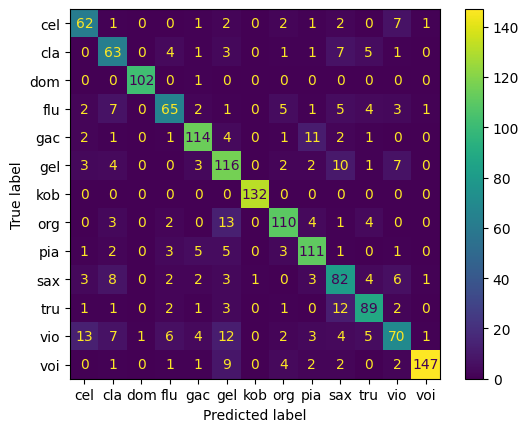

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_preds), display_labels=INS_CODE.keys())
disp.plot()
plt.show()

In [32]:
INS_CODE.keys()

dict_keys(['cel', 'cla', 'dom', 'flu', 'gac', 'gel', 'kob', 'org', 'pia', 'sax', 'tru', 'vio', 'voi'])